<a href="https://colab.research.google.com/github/ShinyRyo/TPU/blob/master/PyTorch_on_TPUs_Fast_Neural_Style_Transfer_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://i.imgur.com/ipYa6Q8.png)

## PyTorch on TPUs: Fast Neural Style Transfer

This notebook lets you run a pre-trained fast neural style transfer network implemented in PyTorch on a Cloud TPU. You can combine pictures and styles to create fun new images. 

You can learn more about fast neural style transfer from its implementation [here](https://github.com/pytorch/examples/tree/master/fast_neural_style) or the original paper, available [here](https://arxiv.org/abs/1603.08155).

This notebook loads PyTorch and stores the network on your Google drive. After this automated setup process (it takes a couple minutes) you can put in a link to an image and see your style applied in seconds!

You can find more examples of running PyTorch on TPUs [here](https://github.com/pytorch/xla/tree/master/contrib/colab), including tutorials on how to run PyTorch on hundreds of TPUs with Google Cloud Platform. 

### Installs PyTorch & Loads the Networks
(This may take a couple minutes.)

Fast neural style transfer networks use the same architecture but different weights to encode their styles. This notebook creates four fast neural style transfer networks: "rain princess," "candy," "mosaic," and "udnie." You can apply these styles below.

In [0]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  49011      0 --:--:-- --:--:-- --:--:-- 49011
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
Uninstalling torch-1.5.0+cu101:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torch-1.5.0+cu101
Uninstalling torchvision-0.6.0+cu101:
  Successfully uninstalled torchvision-0.6.0+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
\ [1 files][114.5 MiB/114.5 MiB]                                                
Operation completed over 1 objec

In [0]:
from google.colab.patches import cv2_imshow
import cv2
import sys

# Configures repo in local colab fs
REPO_DIR = '/demo'
%mkdir -p "$REPO_DIR"
%cd "$REPO_DIR" 
%rm -rf examples
!git clone https://github.com/pytorch/examples.git 
%cd "$REPO_DIR/examples/fast_neural_style"

# Download pretrained weights for styles
!python download_saved_models.py
%cd "$REPO_DIR/examples/fast_neural_style/neural_style"


## Creates pre-trained style networks
import argparse
import os
import sys
import time
import re

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
import utils
from transformer_net import TransformerNet
from vgg import Vgg16

# Acquires the XLA device (a TPU core)
device = xm.xla_device()

# Loads pre-trained weights
rain_princess_path = '../saved_models/rain_princess.pth'
candy_path = '../saved_models/candy.pth'
mosaic_path = '../saved_models/mosaic.pth'
udnie_path = '../saved_models/udnie.pth'

# Loads the pre-trained weights into the fast neural style transfer
# network architecture and puts the network on the Cloud TPU core.
def load_style(path):
  with torch.no_grad():
    model = TransformerNet()
    state_dict = torch.load(path)
    # filters deprecated running_* keys from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    model.load_state_dict(state_dict)
    return model.to(device)

# Creates each fast neural style transfer network
rain_princess = load_style(rain_princess_path)
candy = load_style(candy_path)
mosaic = load_style(mosaic_path)
udnie = load_style(udnie_path)

/demo
Cloning into 'examples'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 2456 (delta 0), reused 1 (delta 0), pack-reused 2451
Receiving objects: 100% (2456/2456), 39.06 MiB | 18.42 MiB/s, done.
Resolving deltas: 100% (1224/1224), done.
/demo/examples/fast_neural_style
/usr/local/lib/python3.6/dist-packages/torch/hub.py:439: UserWarning: torch.hub._download_url_to_file has been renamed to            torch.hub.download_url_to_file to be a public API,            _download_url_to_file will be removed in after 1.3 release
  _download_url_to_file will be removed in after 1.3 release')
100% 23.9M/23.9M [00:00<00:00, 78.9MB/s]
/demo/examples/fast_neural_style/neural_style


## Try it out!

The next cell loads and display an image from a URL. This image is styled by the following cell. You can re-run these two cells as often as you like to style multiple images.

Start by copying and pasting an image URL here (or use the default corgi).

--2020-06-02 21:23:29--  https://cdn.pixabay.com/photo/2019/06/11/15/42/corgi-face-4267312__480.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183, 2606:4700::6812:14b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78787 (77K) [image/jpeg]
Saving to: ‘content.jpg’

content.jpg         100%[===================>]  76.94K  --.-KB/s    in 0.01s   

2020-06-02 21:23:30 (6.23 MB/s) - ‘content.jpg’ saved [78787/78787]



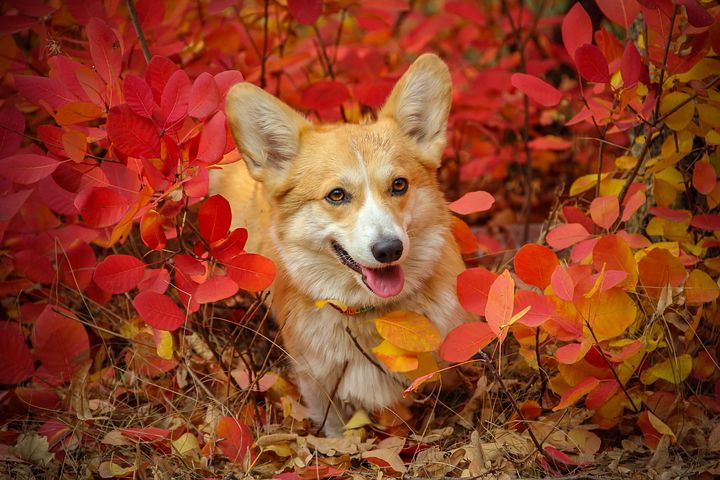

In [0]:
#@markdown ### Image URL (right click -> copy image address):
content_image_url = 'https://cdn.pixabay.com/photo/2019/06/11/15/42/corgi-face-4267312__480.jpg' #@param {type:"string"}
content_image = 'content.jpg'
!wget -O "$content_image" "$content_image_url"
RESULT_IMAGE = '/tmp/result.jpg'
!rm -f "$RESULT_IMAGE"
img = cv2.imread(content_image, cv2.IMREAD_UNCHANGED)

content_image = utils.load_image(content_image, scale=None)
content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0).to(device)

cv2_imshow(img)

To style your image simply uncomment the style you wish to apply below and run the cell!

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2875: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


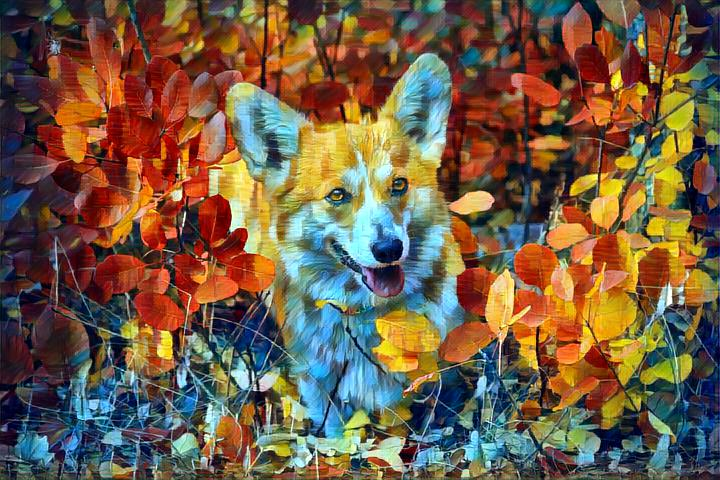

In [0]:
with torch.no_grad():
  output = rain_princess(content_image)
  # output = candy(content_image)
  # output = mosaic(content_image)
  # output = udnie(content_image)


utils.save_image(RESULT_IMAGE, output[0].cpu())
img = cv2.imread(RESULT_IMAGE, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)